In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

print('Import Successful')

Import Successful


In [2]:
import numpy as np
import matplotlib.pyplot as plt

class RNN:

    def __init__(self, char_to_idx, idx_to_char, vocab, h_size=75,
                 seq_len=20, clip_value=5, epochs=50, learning_rate=1e-2):
        self.n_h = h_size  
        self.seq_len = seq_len          # number of characters in each batch
        self.clip_value = clip_value    # max allowed value for the gradients
        self.epochs = epochs  
        self.learning_rate = learning_rate
        self.char_to_idx = char_to_idx  # dictionary that maps characters to an index
        self.idx_to_char = idx_to_char  # dictionary that maps indices to characters 
        self.vocab = vocab              # number of unique characters in the training text
        
        # smoothing out loss 
        self.smooth_loss = -np.log(1.0 / self.vocab) * self.seq_len  

        # initialize parameters
        self.params = {}
        # Weights 
        self.params["W_xh"] = np.random.randn(self.vocab, self.n_h) * 0.01 
        self.params["W_hh"] = np.identity(self.n_h) * 0.01
        self.params["W_hy"] = np.random.randn(self.n_h, self.vocab) * 0.01
        
        # Bias
        self.params["b_h"] = np.zeros((1, self.n_h))
        self.params["b_y"] = np.zeros((1, self.vocab))

        
        self.h0 = np.zeros((1, self.n_h))  # value of the hidden state at time step t = -1

        # Weill be using Adaptive Gradient optimizer (AdaGrad)
        # init Adagrad
        self.grads = {}
        self.m_params = {}

        for key in self.params:
            self.grads["d" + key] = np.zeros_like(self.params[key])
            self.m_params["m" + key] = np.zeros_like(self.params[key])


    def encode_text(self, X):
        X_encoded = []

        for char in X:
            X_encoded.append(self.char_to_idx[char])
        return X_encoded


    def prepare_batches(self, X, index):

        X_batch_encoded = X[index: index + self.seq_len]
        y_batch_encoded = X[index + 1: index + self.seq_len + 1]

        X_batch = []
        y_batch = []

        for i in X_batch_encoded:
            one_hot_char = np.zeros((1, self.vocab))
            one_hot_char[0][i] = 1
            X_batch.append(one_hot_char)

        for j in y_batch_encoded:
            one_hot_char = np.zeros((1, self.vocab))
            one_hot_char[0][j] = 1
            y_batch.append(one_hot_char)
        return X_batch, y_batch


    def softmax(self, x):
        # Activation func
        e_x = np.exp(x - np.max(x)) 
        return e_x / np.sum(e_x)


    def forward_propagation(self, X):

        h = {}              # stores hidden states
        h[-1] = self.h0     # set initial hidden state at t=-1

        y_pred = {}  # stores output probabilities

        # iterate over each character in the input sequence
        for t in range(self.seq_len):
            h[t] = np.tanh(
                np.dot(X[t], self.params["W_xh"]) + np.dot(h[t - 1], self.params["W_hh"]) + self.params["b_h"])
            y_pred[t] = self.softmax(np.dot(h[t], self.params["W_hy"]) + self.params["b_y"])

        self.ho = h[t]
        return y_pred, h


    def backward_propagation(self, X, y, y_pred, h):

        dh_next = np.zeros_like(h[0])

        for t in reversed(range(self.seq_len)):
            dy = np.copy(y_pred[t])
            dy[0][np.argmax(y[t])] -= 1  # predicted y - actual y

            self.grads["dW_hy"] += np.dot(h[t].T, dy)
            self.grads["db_y"] += dy

            dhidden = (1 - h[t] ** 2) * (np.dot(dy, self.params["W_hy"].T) + dh_next)
            dh_next = np.dot(dhidden, self.params["W_hh"].T)

            self.grads["dW_hh"] += np.dot(h[t - 1].T, dhidden)
            self.grads["dW_xh"] += np.dot(X[t].T, dhidden)
            self.grads["db_h"] += dhidden

            # clip gradients to mitigate exploding gradients
        for grad, key in enumerate(self.grads):
            np.clip(self.grads[key], -self.clip_value, self.clip_value, out=self.grads[key])
        return


    def update(self):

        for key in self.params:
            self.m_params["m" + key] += self.grads["d" + key] * self.grads["d" + key]
            self.params[key] -= self.grads["d" + key] * self.learning_rate / (np.sqrt(self.m_params["m" + key]) + 1e-8)


    def test(self, test_size, start_index):

        res = ""

        x = np.zeros((1, self.vocab))
        x[0][start_index] = 1

        for i in range(test_size):
            # forward propagation
            h = np.tanh(np.dot(x, self.params["W_xh"]) + np.dot(self.h0, self.params["W_hh"]) + self.params["b_h"])
            y_pred = self.softmax(np.dot(h, self.params["W_hy"]) + self.params["b_y"])

            # get a random index from the probability distribution of y
            index = np.random.choice(range(self.vocab), p=y_pred.ravel())

            # set x-one_hot_vector for the next character
            x = np.zeros((1, self.vocab))
            x[0][index] = 1

            # find the char with the index and concat to the output string
            char = self.idx_to_char[index]
            res += char
        return res

    def train(self, X):

        J = []

        num_batches = len(X) // self.seq_len

        X_trimmed = X[:num_batches * self.seq_len] # trim end of the input text so that we have full sequences

        X_encoded = self.encode_text(X_trimmed) # transform words to indices to enable processing

        start_time = time.time()
        for i in range(self.epochs):
            
            cur_epoch_time = time.time()
            
            for j in range(0, len(X_encoded) - self.seq_len, self.seq_len):

                X_batch, y_batch = self.prepare_batches(X_encoded, j)
                y_pred, h = self.forward_propagation(X_batch)

                loss = 0
                for t in range(self.seq_len):
                    loss += -np.log(y_pred[t][0, np.argmax(y_batch[t])])
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                J.append(self.smooth_loss)

                self.backward_propagation(X_batch, y_batch, y_pred, h)
                self.update()

            etime = time.time() - cur_epoch_time
            ttime_mins = (time.time() - start_time)  / 60
            
            
            print(f'Epoch: {i+1} / {self.epochs}, Epoch Time: {etime:.2f}, Total Time: {ttime_mins:.2f}, Loss: {loss:.2f}')
        return J, self.params
    

In [4]:
with open('Harry-Potter.txt') as txt:
    text = txt.read().lower()
    
# Will use only part of the whole text to make faster

use_text = text[:40000]

# Extract all unique characters to build vocabulary 
all_chars = set(use_text)
vocab = len(all_chars)

# Create char to index encoding / decoding
char_to_idx = {w:i for i, w in enumerate(all_chars)}
idx_to_char = {i:w for i, w in enumerate(all_chars)}

parameter_dict = {
        'char_to_idx': char_to_idx,
        'idx_to_char': idx_to_char,
        'vocab': vocab,
        'h_size': 50,
        'seq_len': 20,  # keep small to avoid diminishing/exploding gradients
        'clip_value': 5,
        'epochs': 50,
        'learning_rate': 1e-2,
    }


In [5]:
model = RNN(**parameter_dict)
loss, params = model.train(use_text)

Epoch: 1 / 50, Epoch Time: 3.56, Total Time: 0.06, Loss: 41.02
Epoch: 2 / 50, Epoch Time: 3.74, Total Time: 0.12, Loss: 38.89
Epoch: 3 / 50, Epoch Time: 3.64, Total Time: 0.18, Loss: 37.90
Epoch: 4 / 50, Epoch Time: 4.00, Total Time: 0.25, Loss: 37.94
Epoch: 5 / 50, Epoch Time: 3.85, Total Time: 0.31, Loss: 38.14
Epoch: 6 / 50, Epoch Time: 3.75, Total Time: 0.38, Loss: 38.25
Epoch: 7 / 50, Epoch Time: 3.86, Total Time: 0.44, Loss: 38.35
Epoch: 8 / 50, Epoch Time: 4.44, Total Time: 0.51, Loss: 38.36
Epoch: 9 / 50, Epoch Time: 4.29, Total Time: 0.59, Loss: 38.31
Epoch: 10 / 50, Epoch Time: 4.92, Total Time: 0.67, Loss: 38.35
Epoch: 11 / 50, Epoch Time: 4.36, Total Time: 0.74, Loss: 38.37
Epoch: 12 / 50, Epoch Time: 4.77, Total Time: 0.82, Loss: 38.54
Epoch: 13 / 50, Epoch Time: 5.18, Total Time: 0.91, Loss: 38.68
Epoch: 14 / 50, Epoch Time: 4.33, Total Time: 0.98, Loss: 38.83
Epoch: 15 / 50, Epoch Time: 3.93, Total Time: 1.04, Loss: 38.91
Epoch: 16 / 50, Epoch Time: 4.01, Total Time: 1.1

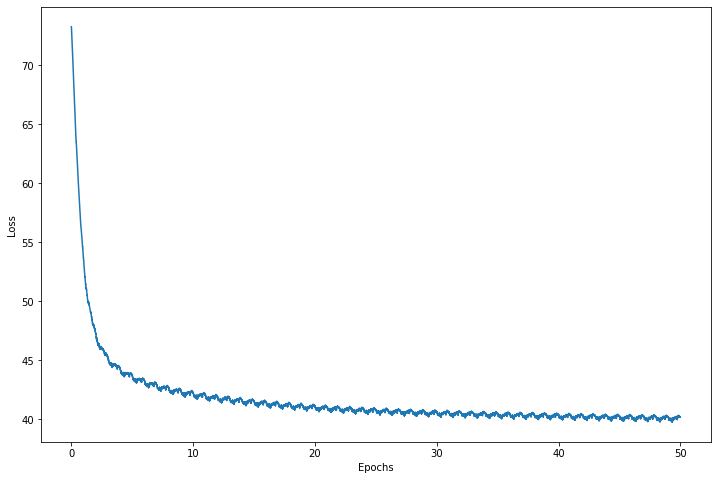

In [6]:
plt.close(1);plt.figure(1,figsize=(12, 8))
plt.plot([i/2000 for i in range(len(loss))], loss)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()